# Primero Encode, luego Estandarizar y gestionar Outliers.

In [73]:
import pandas as pd
import numpy as np

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from itertools import product

from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder

from category_encoders import TargetEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../..")
from src.support_ml import * 

In [74]:
params_tree = {
    'max_depth': [6, 8, 10, 20],
    'min_samples_split': [10, 50],
    'min_samples_leaf': [10, 50],
    'max_leaf_nodes': [10, 20, 40, 80, 160]
}

In [75]:
df = pd.read_csv("../../datos/autorenew.csv")

## EDA and nulls

In [76]:
month_map = {
    0: "unknown",
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september",
    10: "october",
    11: "november",
    12: "december"
}

In [77]:
df["dateCreated"] = pd.to_datetime(df["dateCreated"]).apply(lambda x: x.strftime("%Y-%m"))
df["dateCrawled"] = pd.to_datetime(df["dateCrawled"]).apply(lambda x: x.strftime("%Y-%m"))
df["lastSeen"] = pd.to_datetime(df["lastSeen"]).apply(lambda x: x.strftime("%Y-%m"))

In [78]:
df.drop(index = df[df["price"]<=250].index, inplace=True)

upper_error_index = df[(df["price"] > 1.7e+05) & (df["powerCV"] < 400)].index
df.drop(index=upper_error_index, inplace=True)

df.drop(index = df[df["price"] > 1e+9].index, inplace=True)

cv_cond = (df["powerCV"] < 50) | (df["powerCV"] > 1000)
df.loc[df[cv_cond].index, "powerCV"] = np.nan

cond_year = (df["yearOfRegistration"] < 1900) | (df["yearOfRegistration"] >= 2017)
df.loc[df[cond_year].index, "yearOfRegistration"] = 'unknown'

coche_year_dicc = {
    "Coche Vintage": list(range(1900, 1946)),
    "Coche Clásico": list(range(1946, 1971)),
    "Coche Retro-Moderno": list(range(1971, 1991)),
    "Coche Moderno": list(range(1991, 2011)),
    "Coche Contemporáneo": list(range(2011, 2025)),
    "unknown" : ["unknown"]
}

year_to_category = {}

for category, years in coche_year_dicc.items():
    for year in years:
        year_to_category[year] = category

df["yearOfRegistration"] = df["yearOfRegistration"].map(year_to_category)


df["monthOfRegistration"] = df["monthOfRegistration"].map(month_map)

for col in df.select_dtypes("O").columns:
    df.loc[df[df[col].isna()].index, col] = 'unknown'

df.reset_index(drop=True, inplace=True)

In [79]:
df_treated = impute_nulls(df)

[IterativeImputer] Completing matrix with shape (349204, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 54.29
[IterativeImputer] Change: 419.2934571427641, scaled tolerance: 3895.0 
[IterativeImputer] Early stopping criterion reached.


In [80]:
df_imputed = df.copy()
df_imputed[df_treated.columns] = df_treated

In [81]:
df_imputed.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03,Golf_3_1.6,private,offer,480.0,test,unknown,Coche Moderno,manually,95.12,golf,150000.0,unknown,petrol,volkswagen,unknown,2016-03,0.0,70435.0,2016-04
1,2016-03,A5_Sportback_2.7_Tdi,private,offer,18300.0,test,coupe,Coche Contemporáneo,manually,187.00,unknown,125000.0,may,diesel,audi,yes,2016-03,0.0,66954.0,2016-04
2,2016-03,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800.0,test,suv,Coche Moderno,automatic,161.00,grand,125000.0,august,diesel,jeep,unknown,2016-03,0.0,90480.0,2016-04
3,2016-03,GOLF_4_1_4__3TÜRER,private,offer,1500.0,test,small car,Coche Moderno,manually,74.00,golf,150000.0,june,petrol,volkswagen,no,2016-03,0.0,91074.0,2016-03
4,2016-03,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600.0,test,small car,Coche Moderno,manually,68.00,fabia,90000.0,july,diesel,skoda,no,2016-03,0.0,60437.0,2016-04


## Encoding

In [82]:
df_imputed.drop(columns=['name', 'model', 'postalCode'], inplace=True)

In [83]:
onehot_abtest = encode_onehot(df_imputed, columns=["abtest"])
df_noout_onehot = pd.concat([df_imputed.reset_index(drop=True), onehot_abtest.reset_index(drop=True)], axis=1)

In [84]:
df_noout_onehot.drop(columns=["seller", "offerType", "abtest"], inplace=True)
df_noout_onehot.reset_index(drop=True, inplace=True)

In [85]:
df_encoded = encode_target(df_noout_onehot, columns = df_noout_onehot.select_dtypes('O').columns, response_var="price")

## Feature Scaling

In [ ]:
df_encoded.drop(columns="nrOfPictures", inplace=True)

In [92]:
numeric_cols = df_encoded.select_dtypes("number").columns.drop("price")

In [ ]:
df_scaled = scale_data(data =df_encoded, columns = numeric_cols)

In [99]:
df_imputed_scaled = df_encoded.copy()

In [100]:
df_imputed_scaled[df_scaled.columns] = df_scaled

In [101]:
df_imputed_scaled.head(2)

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,abtest_control,abtest_test
0,0.0,480.0,0.000000,0.000000,0.0,-0.299683,0.0,-9.841127,0.0,0.000000,-1.000000,0.0,0.0,0.0,0.0
1,0.0,18300.0,14.089543,10698.085712,0.0,1.158730,-0.5,-0.381729,1.0,0.775645,-1.277697,0.0,0.0,0.0,0.0


## Outliers

In [107]:
ifo_outliers = find_outliers(data = df_imputed_scaled, columns = numeric_cols)

100%|██████████| 25/25 [09:57<00:00, 23.90s/it]


In [112]:
df_drop_ifo = df_imputed_scaled.drop(index = ifo_outliers.index)
df_drop_ifo.reset_index(drop=True, inplace=True)

In [109]:
lof_outliers = find_outliers(data = df_drop_ifo, columns = numeric_cols)

100%|██████████| 25/25 [09:33<00:00, 22.95s/it]


In [114]:
numeric_cols

Index(['dateCrawled', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerCV', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'lastSeen', 'abtest_control',
       'abtest_test'],
      dtype='object')

In [115]:
real_numeric_cols = ["powerCV", "kilometer"]

In [116]:
df_drop_ifo.loc[lof_outliers.index, real_numeric_cols] = np.nan

df_lof_imputed = impute_nulls(data = df_drop_ifo)

[IterativeImputer] Completing matrix with shape (339408, 15)
[IterativeImputer] Ending imputation round 1/10, elapsed time 333.27
[IterativeImputer] Change: 8.177757607756817, scaled tolerance: 500.0 
[IterativeImputer] Early stopping criterion reached.


In [117]:
df_drop_ifo.loc[lof_outliers.index, numeric_cols] = df_lof_imputed

In [118]:
df_noout = df_drop_ifo

## Training

In [120]:
X = df_noout.drop(columns= ["price"])
y = df_noout["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
params_tree = {
    'max_depth': [6, 8, 10, 20],
    'min_samples_split': [10, 50],
    'min_samples_leaf': [10, 50],
    'max_leaf_nodes': [10, 20, 40, 80, 160]
}

In [122]:
grid_search_tree = create_model(X_train=X_train, y_train=y_train, params=params_tree, method = DecisionTreeRegressor())

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [123]:
best_tree = grid_search_tree.best_estimator_

In [124]:
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

get_metrics(y_train, y_train_pred, y_test, y_test_pred)

,r2_score,MAE,MSE,RMSE
train,0.700391,2117.206282,1.551556e+07,3938.979232
test,0.693004,2130.679252,1.534460e+07,3917.218443


In [125]:
params_gb = {'n_estimators': [90,110],
            'max_depth': [4, 5, 6],
            'min_samples_split': [10, 15, 20],
            'min_samples_leaf': [5, 7, 9],
            'max_leaf_nodes': [70,80,90]}

In [126]:
X_sample = X_train.sample(10000, random_state=42)
y_sample = y_train.sample(10000, random_state=42)

In [127]:
grid_search_gb = create_model(params=params_gb, X_train=X_sample, y_train=y_sample, method = GradientBoostingRegressor(random_state=42, learning_rate=0.1), cv = 3)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [128]:
grid_search_gb.best_params_

{'max_depth': 6,
 'max_leaf_nodes': 70,
 'min_samples_leaf': 9,
 'min_samples_split': 20,
 'n_estimators': 90}

In [129]:
gb_estimator = grid_search_gb.best_estimator_

In [130]:
y_test_pred_gb = gb_estimator.predict(X_test)
y_train_pred_gb = gb_estimator.predict(X_train)

In [131]:
get_metrics(y_train, y_train_pred_gb, y_test, y_test_pred_gb)

,r2_score,MAE,MSE,RMSE
train,0.712446,1948.400531,1.489126e+07,3858.919689
test,0.719803,1961.921299,1.400511e+07,3742.339597


<Axes: xlabel='price'>

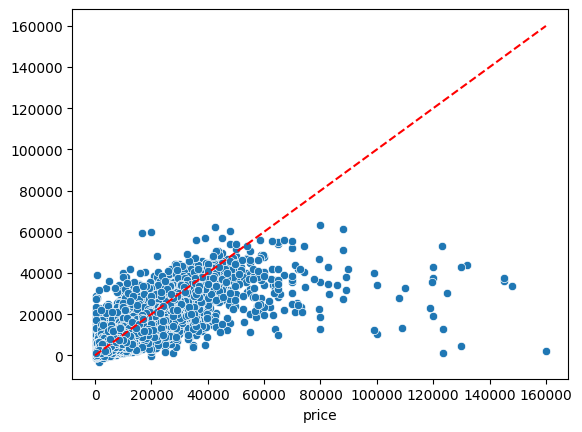

In [132]:
plt.plot([0, max(y_test)], [0, max(y_test)], ls = "--", color = "red")
sns.scatterplot(x = y_test, y = y_test_pred_gb)

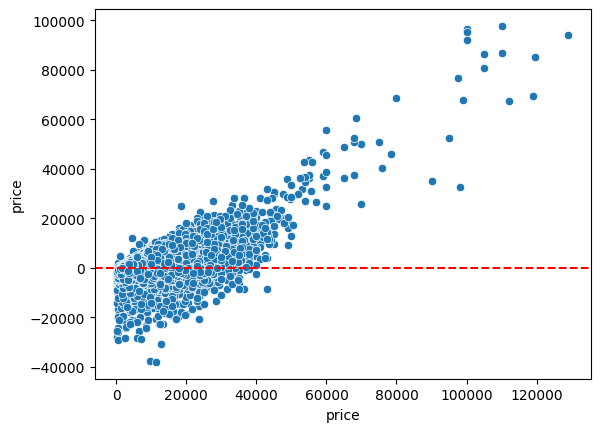

In [48]:
sns.scatterplot(x = y_test, y = y_test-y_test_pred_gb)
plt.axhline(y = 0, ls = "--", color = "red")